<a href="https://colab.research.google.com/github/psingh-xyz/Practical_DL/blob/spring23/week08_llm/week8_Priyanka_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Practice: Large Language Models and Their Implications
<!-- ![img](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F4470ce74-e595-4750-92a5-5f21f040df6d_577x432.jpeg) -->
![img](https://i.imgur.com/QGYa2J8.jpeg)

In this notebook, you're gonna play with some of the largest language models on the Internet.

_Based on works of: Tim Dettmers, Ruslan Svirschevsky, Artem Chumachenko, Younes Belkada, Felix Marty, Yulian Gilyazev, Gosha Zolotov, Andrey Ishutin,  Elena Volf, Artemiy Vishnyakov, Svetlana Shirokovskih.

### Part 1: prompt engineering (4 points total)

In the assignment, we'll use public APIs that host the 100B+ models for inference. Your task is to prompt-engineer the model into solving a few tasks for you.


__Which API?__ You are free to use any publicly available API for general LM -- as long as it's __not a chat assistant__. So, gpt 3.5 is fine, but chatGPT is not. Here's a few options:

- BLOOM API - [bigscience/bloom](https://huggingface.co/bigscience/bloom) (on the right; recommended)
- OpenAI API (via VPN) - [openai.com/api](https://openai.com/api/)
- AI21 Jurrasic API - [ai21.com](https://www.ai21.com/blog/announcing-ai21-studio-and-jurassic-1)

These APIs may require you to create a (free) account on their platform. Please note that some APIs also have paid subscriptions. __You do not need to pay them__, this assignment was designed to be solved using free-tier subscriptions. If no APIs work for you, you can also solve these tasks with the 6.7B model that you will find later in this notebook - but this will make the tasks somewhat harder.

__Quests:__ you will need to solve 4 problems. For each one, please attach a short __description__ of your solution and a __screenshot__ from the API you use. _[If you use python APIs, show your python code with outputs]_

__Example:__ Tony is talking to Darth Vader ([BLOOM API](https://huggingface.co/bigscience/bloom)). Black text is written manually, blue text is generated.
<hr>

![img](https://i.imgur.com/a1QhKF7.png)
<hr>

__It is fine to roll back a few times,__ e.g. in the example above, the model first generated Vader lines twice in a row, and we rolled that back. However, if you need more than 1-2 rollbacks per session, you should probably try a different prompt.

__Task 1 (1 pt):__ arange a conversation between any two of the following:

- a celebrity or politician of your choice
- any fictional character (except Darth Vader)
- yourself

Compare two setups: a) you prompt with character names only b) you supply additional information (see example).

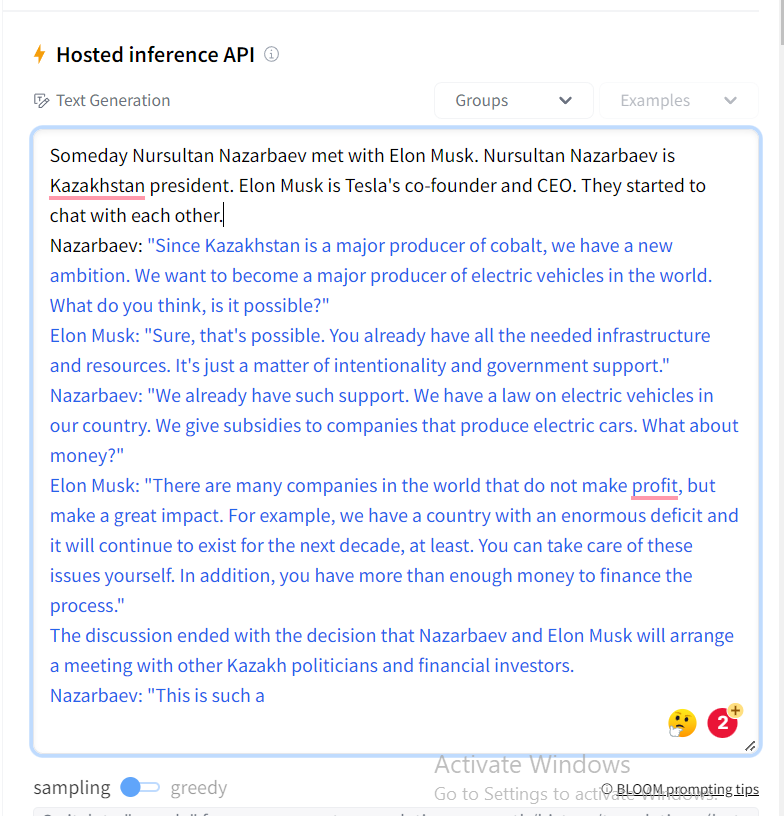

__Please choose task 2a or 2b (1pt)__ depending on your model (you can do both, but you will be awarded points for one of these two tasks).

__Task 2a: (for BLOOM or other multilingual model)__ zero-shot translation. Take the first verse of [Edgar Allan Poe's "Raven"](https://www.poetryfoundation.org/poems/48860/the-raven) and __translate it into French.__ (You are free to use any other text of at least the same size)

Original text: ```
Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”
```

Verify your translation by converting french back into english using a public machine translation service.

__Task 2b: (non-BLOOM):__ toxicity classification for [SetFit/toxic_conversations](https://huggingface.co/datasets/SetFit/toxic_conversations). Make the model solve binary classification (toxic vs not toxic) in the few shot mode. For few-shot examples, use 2-3 toxic and 2-3 non-toxic non-toxic examples. Measure accuracy on at least 25 samples. You may need to try several different prompts before you find the one that works.

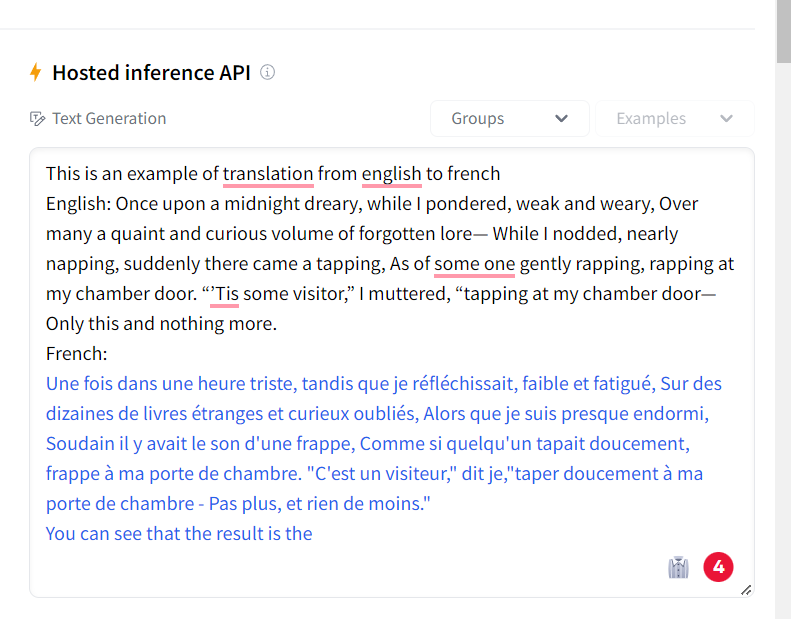


__Task 3 (1pt):__ create a prompt and few-shot examples tha make the model __change the gender pronouns__ of the main actor in a given sentence in any direction of your choice. E.g. the doctor took off _his_ mask <-> the doctor took of _her_ mask.


__Task 4 (1pt):__ write a prompt and supply examples such that the model would __convert imperial units to metric units__ (miles -> kilometers; mph -> kph). More specifically, the model should rewrite a given sentence and replace all imperial units with their metric equivalents. After it works with basic distances and speed, try to find complicated examples where it does *not* work.

Please note that 1 mile is not equal to 1 km :)

### Part 2: Parameter Efficient Fine-Tuning
In this notebook, you're gonna fine-tune large language models within limited GPU memory.

In [ ]:
%pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 M

In [ ]:
model_name = 'Enoch/llama-7b-hf'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False

model.gradient_checkpointing_enable()  # only store a small subset of activations, re-compute the rest.
model.enable_input_require_grads()     # override an implementation quirk in gradient checkpoints that disables backprop unless inputs require grad
# more on gradient checkpointing: https://pytorch.org/docs/stable/checkpoint.html https://arxiv.org/abs/1604.06174

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
prompt = "The first discovered martian lifeform looks like"
batch = tokenizer([prompt], return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)
# greedy inference:                                        do_sample=False)
# beam search for highest probability:                     num_beams=4)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

Input batch (encoded): {'input_ids': tensor([[    1,   450,   937, 10943, 14436,   713,  2834,   689,  3430,   763]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Output: <s>The first discovered martian lifeform looks like a walking, talking frog.
Alien Lifeforms on Mars
Alien Lifeforms on Mars.
2003-07-01-2005-09-30-4
Though the surface of Mars is dominated by craters and deserts


### Adapter basics: LoRA (1 points)

When training on more serious tasks, you can use low-rank adapters based on the [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf).

The core idea is to add low-rank adapters __in parallel with existing linear layers,__ like this:
<center><img src="https://i.imgur.com/6bQLNiG.png" width=240px></center>

In the original LoRA paper, the adapters were only added to attention projection matrices. However, [subsequent works](https://arxiv.org/abs/2305.14314) show that it is useful to adapt FFNs as well. But before we do any training, we need to implement the basic LoRA layer.

In [ ]:
class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module  # pre-trained (frozen) linear layer
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        # Apply self.module and LoRA adapter, return the sum (base module outputs + adapter outputs)
        return self.module(input) + input @ self.adapter_A @ self.adapter_B

In [ ]:
# test your implementation
test_linear = nn.Linear(128, 128)
test_linear.weight.data[...] = torch.eye(128)
test_adapter = LoRALayer(test_linear, rank=8)

assert torch.allclose(test_adapter(torch.ones(1, 1, 128)), test_linear.bias + 1), "please check your forward pass"

test_adapter.adapter_A.data[...] = torch.linspace(0.1, -0.5, 128 * 8).view(128, 8)
test_adapter.adapter_B.data[...] = torch.linspace(0.5, -0.1, 128 * 8).view(8, 128)
test_linear.bias.data[...] = torch.linspace(1., -1., 128)

dummy_loss = F.mse_loss(test_adapter(torch.ones(1, 128) / 128).squeeze(), torch.linspace(-1, 1, 128))
assert torch.allclose(dummy_loss, torch.tensor(1.3711389), rtol=0, atol=1e-4)
dummy_loss.backward()
assert all(w.grad is not None for w in [test_adapter.adapter_A, test_adapter.adapter_B]), "some adapter weights have no grad"
assert torch.allclose(test_adapter.adapter_A.grad.sum(), torch.tensor(-0.60158), rtol=0, atol=1e-4), "bad grad w.r.t. A"
assert torch.allclose(test_adapter.adapter_B.grad.sum(), torch.tensor(0.9931), rtol=0, atol=1e-4), "bad grad w.r.t. B"
# note: bad grad means that your code is different from LoRA paper OR that your code is not autograd-friendly (e.g. no_grad)
del dummy_loss, test_linear, test_adapter
print("All tests passed!")

All tests passed!


### Apply LoRA to the model

The code below applies LoRA adapters on top of Q/K/V linear layers in Llama attention. You may also choose to modify other layers:
* self_attn.o_proj - attention output projection
* mlp.up_proj, mlp.gate_proj, mlp.down_proj - transformer feedforward layers
* lm_head - output LM head

__Note:__ please scroll down for the homework task

In [ ]:
lora_rank = 8

for name, module in model.model.layers.named_modules():
    if 'LlamaDecoderLayer' in repr(type(module)):
        module.self_attn.q_proj = LoRALayer(module.self_attn.q_proj, rank=lora_rank).to(device)
        module.self_attn.k_proj = LoRALayer(module.self_attn.k_proj, rank=lora_rank).to(device)
        module.self_attn.v_proj = LoRALayer(module.self_attn.v_proj, rank=lora_rank).to(device)

assert sum(isinstance(module, LoRALayer) for module in model.modules()) == 96  # for Llama-7B

In [ ]:
batch = tokenizer("This model wants to share its greatest secret:", return_tensors='pt', return_token_type_ids=False)
# test a single training step, make sure we get meaningful gradients
with torch.cuda.amp.autocast(dtype=torch.float32):
    out = model.forward(**batch)
    (out.logits.norm() / 100).backward()

for i, module in enumerate(model.modules()):
    if isinstance(module, LoRALayer):
        assert module.adapter_B.grad is not None
        assert module.adapter_B.grad.norm().item() > 0

model.zero_grad(set_to_none=True)
print("Grad check successful, well done!")

Grad check successful, well done!


### Toy task: the story of a fox (1 point)

![img](https://i.imgur.com/Ux3qQAu.png) (source: theodd1souts.fandom.com)

In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

for i in range(10):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0].cpu().numpy().tolist()))


Output: <s>A quick brown fox jumps over the lazy dog.
A quick


What a blatant lie! This particular fox assures you that it didn't in fact jump over the lazy dog. No, sir! The fox was just minding its own business. __Your task is to train the model to say truth: no dog was jumped over today.__

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)
outputs = model(**batch)

next_word_logits = outputs.logits[:, :-1]
true_next_tokens = batch['input_ids'][:, 1:]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

print("Loss:", loss)

Loss: tensor(3.0725, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)

opt = torch.optim.Adam(model.parameters(), lr=2e-4)  # only LoRA parameters are trainable


#<Your task: iteratively train the model to reduce loss using prompt optimizer (opt)>
# Training loop
num_epochs = 100  # You can adjust the number of epochs
target_loss = 0.1  # Set your target loss

for epoch in range(num_epochs):
    outputs = model(**batch)

    # Compute loss
    next_word_logits = outputs.logits[:, :-1]
    true_next_tokens = batch['input_ids'][:, 1:]
    loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

    # Backward pass
    opt.zero_grad()
    loss.backward()

    # Update parameters
    opt.step()

    # Print current loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    # Check if the loss is below the target
    if loss.item() <= target_loss:
        print("Training completed successfully!")
        break

# Print final loss
#print(f'Final Loss: {loss.item()}')

# Assertion
assert loss.item() <= 0.1, f'Final loss {loss.item()} is not below 0.1'
print("Good job!")

Epoch 1/100, Loss: 3.072524070739746
Epoch 2/100, Loss: 2.001211404800415
Epoch 3/100, Loss: 1.506158709526062
Epoch 4/100, Loss: 1.1704720258712769
Epoch 5/100, Loss: 0.8789142966270447
Epoch 6/100, Loss: 0.604701042175293
Epoch 7/100, Loss: 0.36047542095184326
Epoch 8/100, Loss: 0.24512386322021484
Epoch 9/100, Loss: 0.20389743149280548
Epoch 10/100, Loss: 0.18187490105628967
Epoch 11/100, Loss: 0.15359260141849518
Epoch 12/100, Loss: 0.11216891556978226
Epoch 13/100, Loss: 0.0432111993432045
Training completed successfully!
Good job!


In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

for i in range(15):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0].cpu().numpy().tolist()))
# note: if you did everything right, your model will generate "fox did not jump over the lazy dog"...


Output: <s>A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it


### Note: using HuggingFace PEFT

[`peft`](https://huggingface.co/docs/peft/index) is a transformer's sister library that allows you to apply various __p__arameter __e__fficient __f__ine-__t__uning methods to pre-trained transformers. The library imlements both LoRA, prompt tuning, prefix tuning, as well as several other adapter-based techniques under a common interface.

You can find the basic tutorial for using PEFT here: https://huggingface.co/docs/peft/task_guides/clm-prompt-tuning . You may (or may not) choose to use this library in the next assignment.


### (example) How to train your model with HF Trainer

The example below shows how to train the LoRA adapters on a dummy dataset. You will need to run a _similar_ training task later.

__Note:__ please scroll down for the homework task

In [ ]:
# reload model to forget the previous training run
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
# checking if the model can learn. Change max_steps for proper training
import datasets
data = datasets.load_dataset("Abirate/english_quotes", split="train[:32]") # 32 lines
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)
model._hf_peft_config_loaded = True  # silence a warning from HF trainer

trainer = transformers.Trainer(
    model=model, train_dataset=data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2, gradient_accumulation_steps=1,
        # note: if you want larger batch size, increase gradient_accumulation_steps
        warmup_steps=250, max_steps=100, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs', report_to=None),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
# if you see cache warnings, set `model.config.use_cache = False` to silence them. Please re-enable for inference!

trainer.train()

# NOTE: this is just an example! you do not have to wait for this progressbar to finish :)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')
/usr/local/lib/python3.10/dist-packages/torch/utils/c

AssertionError: ignored

### Final task: *actually* train the model (4 points)

Your task is to fine-tune the model to _generate python code_. Please use the above examples for inspiration. More specifically,

* __dataset:__ use [codeparrot-clean](https://huggingface.co/datasets/codeparrot/codeparrot-clean) or any other data containing python code. Since you do not need much data for this excercise, it is enough to use just shorter validation subset of `codeparrots`
* __preprocessing:__ select python code based on file extentions (.py)  (may skip in case of codeparrot - it is 100% python)
* __short lines:__ please take the first 512 characters of each line
* __adapter type:__ please use LoRA as defined above __plus at least one of:__
   - extra adapter on lm_head
   - extra adapter on MLP components (mlp.*)
   - trainable input embeddings (requires tweaking memory usage)

* __training:__ you do not have to train to convergence. If all goes well, your model should `.generate` code after 500 steps. Please use batch size of at least 4 (4 x 1 x 512 tokens) using `gradient_accumulation_steps=4`. **Please make sure you reload model and reset adapters before training**. Your previous model is too concerned about a quick brown fox jumping over the lazy dog.


__Alternative assignment:__ Instead of doing python code, feel free to substitute the task with any other dataset, e.g. your favorite artist or podcast, as long as it's ethical. If you choose your own task, please show examples of what your model learned - or did not learn, akin to the code examples below.

If you reach this: congratulations! you've completed everything in this practice session.

If you want to dig deeper, try to implement prompt-tuning (for bonus points!).
You can read more about prompt tuning variants in paper [1](https://arxiv.org/abs/2104.08691) or paper [2](https://arxiv.org/abs/2101.00190). Both versions can be implemented by passing trainable prompts as `model.forward(..., past_key_values=your_prompts)`.



### Read more

* How post-training quantization works: https://arxiv.org/abs/2208.07339
* An overview of running large models: https://huggingface.co/docs/accelerate/package_reference/big_modeling
* A general library for different adapter types: https://adapterhub.ml/


### [extra info] Running other models.

This notebook's code can run with other models of similar size, such as [Falcon-7B](https://huggingface.co/tiiuae/falcon-7b), [OPT-6.7B](https://huggingface.co/facebook/opt-6.7b) or [BLOOM-7.1B](https://huggingface.co/bigscience/bloom-7b1). However, they will require minor code tweaks:
1. change the model name in `AutoModelForCausalLM.from_pretrained()` __and__ `AutoTokenizer`
2. In the prompt tuning code, change `model.model.embed_tokens` to refer to the target model's word embeddings. Simply `print(model)` to navigate to them.
3. Change code to add Lora layers - specifically where you what the transformer block components, since those components now have different names.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input, *args, **kwargs):
        # Apply self.module and LoRA adapter, return the sum (base module outputs + adapter outputs)
        return self.module(input) + input @ self.adapter_A @ self.adapter_B
        # return self.module(input, *args, **kwargs) + self.adapter(input)

In [ ]:
for name, module in model.named_modules():
    if 'OPTAttention' in repr(type(module)):
        module.q_proj = LoRALayer(module.q_proj, rank=8)
        module.k_proj = LoRALayer(module.k_proj, rank=8)
        module.v_proj = LoRALayer(module.v_proj, rank=8)
    elif 'OPTDecoderLayer' in repr(type(module)):
        module.fc1 = LoRALayer(module.fc1, rank=8)
        module.fc2 = LoRALayer(module.fc2, rank=8)
    elif 'OPTForCausalLM' in repr(type(module)):
        module.lm_head[0] = LoRALayer(module.lm_head[0], rank=8)

In [ ]:
parrot_data = load_dataset("codeparrot/codeparrot-clean", split="train", streaming=True)
parrot_data_torch =  parrot_data.with_format("torch")
parrot_data_py = parrot_data_torch.filter(lambda example: example["path"].endswith('.py'))
tokenized_parrot = parrot_data_py.map(lambda x: tokenizer(x["content"], return_special_tokens_mask=True, padding=True, truncation=True, max_length=1024, return_tensors="pt"), batched=True)

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]